In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
%load_ext Cython

In [58]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%cython

import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)

def Mnn(np.ndarray[double, ndim=2] X,int M):
    cdef int n = X.shape[0]
    
    if M > n-1: 
        M = n-1
        print('M jest zbyt duze. Obliczenia zostaną wykonane dla M={}.'.format(M))
        return
    
    cdef np.ndarray[int, ndim=2] S = np.array([0]*(n*M)).reshape(n,M)
    cdef np.ndarray[double, ndim=1] x,y,tmp
    cdef np.ndarray[long long, ndim=1] s
    cdef double e
    
    for i in range(n):
        x = X[i,:]
        tmp = np.array([0.0]*n)
        for j in list(range(i)) + list(range(i+1, n)):
            y = X[j,:]
            e = np.sqrt(np.sum((x-y)*(x-y)))
            tmp[j] = e
        s = np.argsort(tmp)
        s = s[s != i]
        S[i,:] = s[:M]
    return S

def DFS(np.ndarray[int, ndim=2] G, v, np.ndarray[int, ndim=1] visited = np.array([],dtype=int)):
    cdef int n = G.shape[0]
    cdef np.ndarray[int, ndim=1] neighbors = G[v]

    if len(visited) == 0:
        visited = np.array([0]*n)
        
    visited[v] = 1
    for u in np.where([neighbors != 0])[1]:
        if visited[u] == 0:
            DFS(G, u, visited)
    return visited

def Mnn_graph_c(np.ndarray[int, ndim=2] S):
    cdef int n = S.shape[0]
    cdef np.ndarray[int, ndim=2] G = np.array([0]*(n*n)).reshape(n,n)
    cdef np.ndarray[int, ndim=1] si, sj
    
    for i in range(n):
        si = S[i,:]
        for j in range(i):
            sj = S[j,:]
            if len(si[si==j])==1 or len(sj[sj==i])==1:
                G[i,j]=1
                G[j,i]=1
                
    cdef list l = []             
    cdef int t
    cdef int p = 0
    cdef np.ndarray[int, ndim=1] visited = DFS(G, p)
    while not np.all(visited):
        t = np.argmin(visited)
        l.append((p,t))
        p = t
        visited = DFS(G, t, visited)
    
    for k in l:
        G[k[0],k[1]]=1
        G[k[1],k[0]]=1
    
    return G

In [3]:
def Mnn_graph(S):
    return Mnn_graph_c(S)

def Laplacian_eigen(G, k):
    n = G.shape[0]
    D = np.array([0]*(n*n)).reshape(n,n)
    diag = np.sum(G, axis=1)
    D[range(n),range(n)] = diag
    L = D-G
    
    values, vectors = np.linalg.eig(L)
    sort = np.argsort(values)
    values = values[sort]
    vectors = vectors[:,sort]
    E = vectors[:,1:k+1]
    return E

def spectral_clustering(X,k,M):
    E = Laplacian_eigen(Mnn_graph(Mnn(X,M)),k)
    kmeans = KMeans(n_clusters = k).fit(E)
    return kmeans.labels_

In [65]:
def test(X, k, max_m):
    for M in range(1, max_m + 1):
        t = spectral_clustering(X, k, M)

        tmp = pd.DataFrame(X)
        tmp['k'] = t
        tmp.columns = ['x','y','k']
        sns.scatterplot(data=tmp, x="x", y="y", hue="k", palette="Dark2")
        ax = plt.gca()
        ax.set_title("M={}".format(M))
        plt.show()

In [66]:
def test2(X, k, max_m):
    for M in range(1, max_m + 1):
        t = spectral_clustering(X, k, M)

        tmp = pd.DataFrame(X)
        tmp['k'] = t
        tmp.columns = ['x','y','k']
        sns.scatterplot(data=tmp, x="x", y="y", hue="k", palette="Dark2")
        ax = plt.gca()
        ax.set_title("M={}".format(M))
        plt.axhline(y=1, color='#A9A2A1', linestyle='--')
        plt.axhline(y=2, color='#A9A2A1', linestyle='--')
        plt.show()

In [47]:
np.random.seed(123)
plt.rcParams["figure.figsize"] = (8,6)

## Test 1

W pierwszym przypadku sprawdzimy jak algorytm zachowuje się na 'łatwym' zbiorze punktów w przestrzeni dwuwymiarowej. W tym celu wygenerujemy trzy skupiska punktów z rozkładu normalnego (różne średnie, nie za duże odchylenie).

In [ ]:
X1 = np.random.normal(0, 0.5, 2*n).reshape(n,2)
X2 = np.random.normal(3, 0.5, 2*n).reshape(n,2)
X3 = np.random.normal(-3, 0.5, 2*n).reshape(n,2)
X = np.r_[X1, X2, X3]

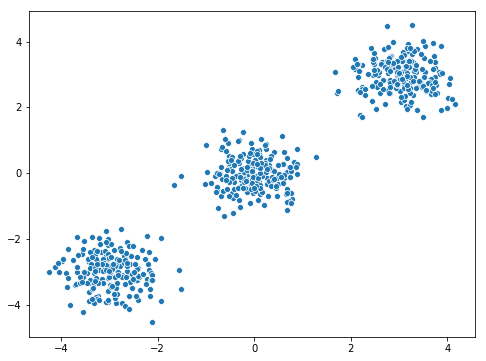

In [74]:
sns.scatterplot(x = X[:,0], y = X[:,1])
plt.show()

Wynik działania algorytmu różni się w zależności od wybranego M. Nie jest niespodzianką, że czym M jest mniejsze, tym jest gorzej. Jednak już dla M=4 sytuacja się stabilizje i klasy są przypisywane poprawnie.

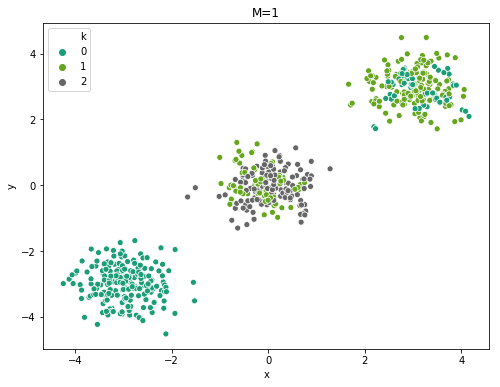

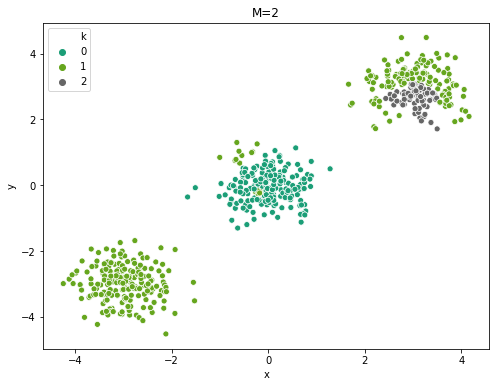

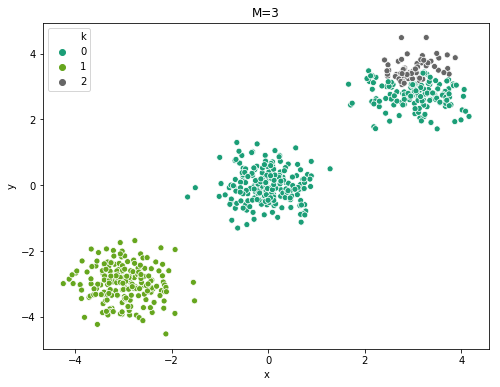

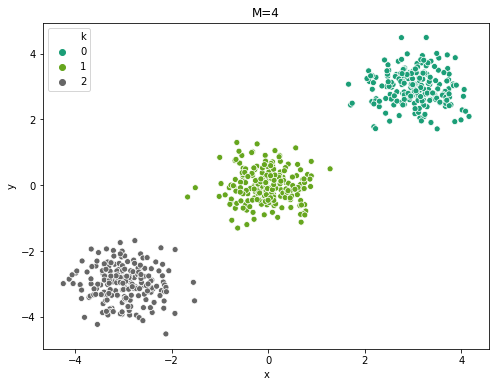

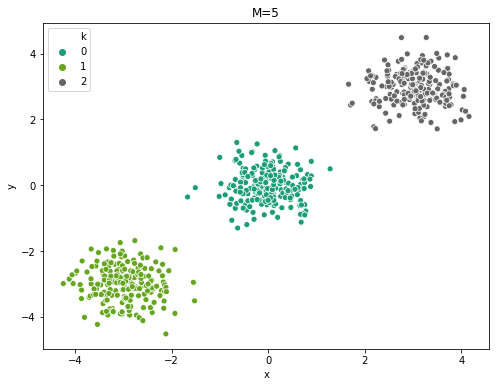

In [75]:
test(X, 3, 5)

Gorzej jeżeli próbujemy podzielić wygenerowane punkty na inną niż trzy liczbę klas. Dla k=2 od M=4 algorytm do jednego skupiska wrzuca dwie z trzech chmur punktów (w różnych konfiguracjach), a do drugiego trzecią. Dla k=4 od pewnego M dzieli na dwie części punkty ze skupiska o dodatnich współrzędnych.

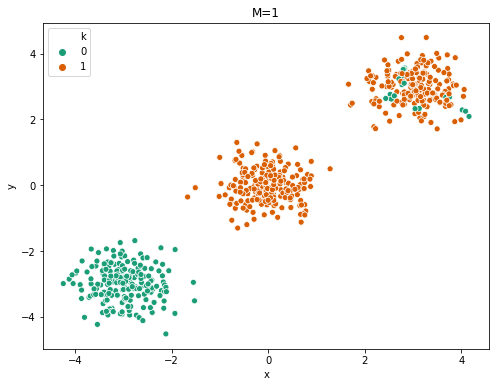

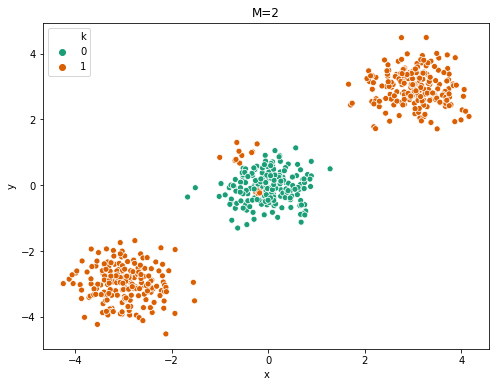

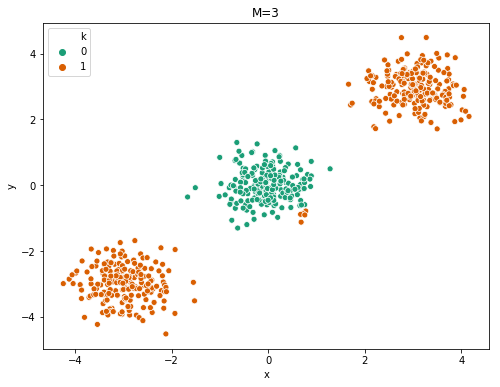

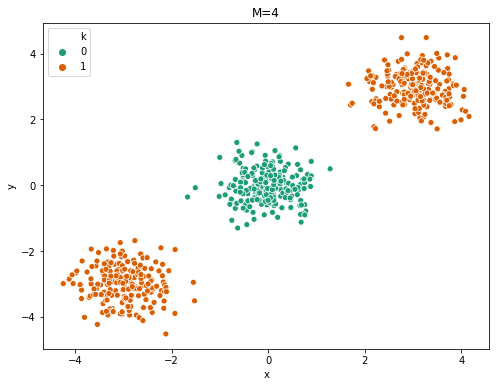

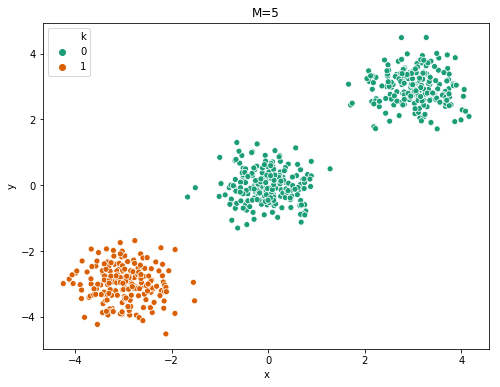

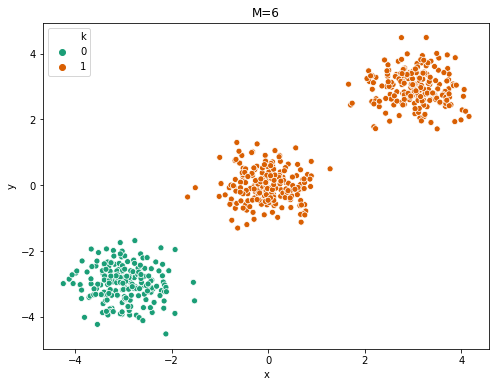

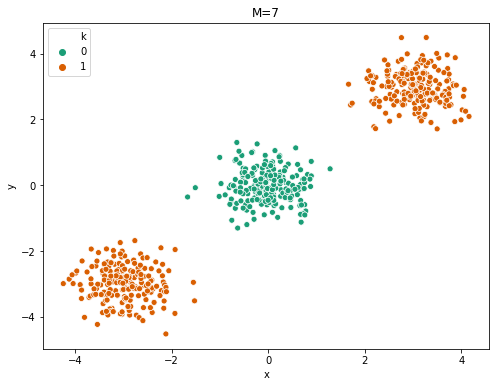

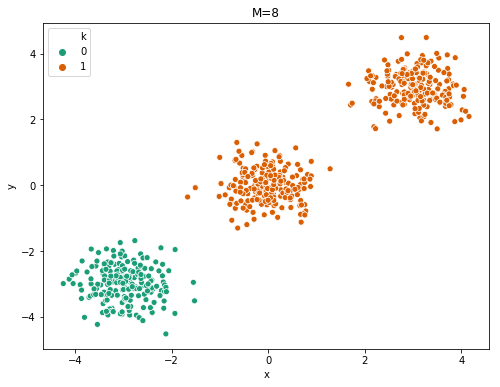

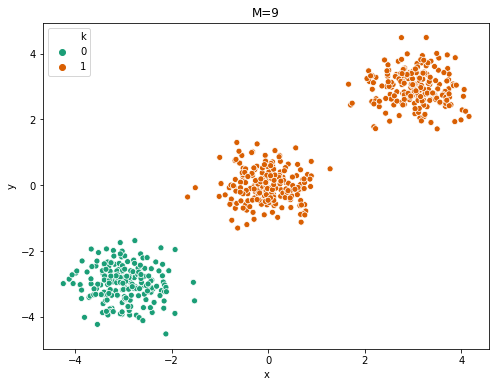

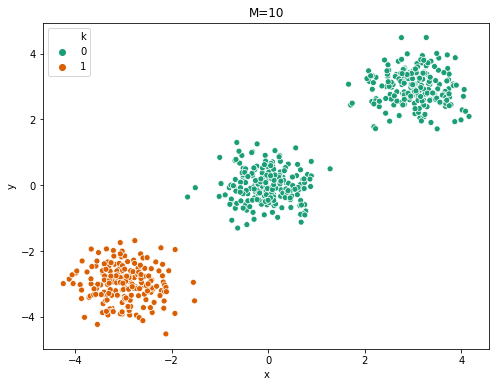

In [76]:
test(X, 2, 10)

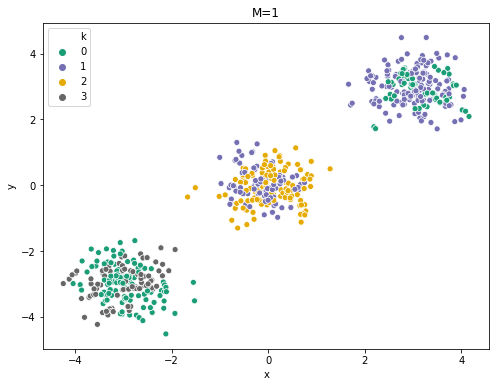

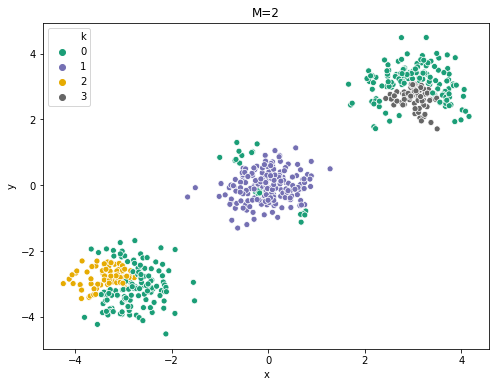

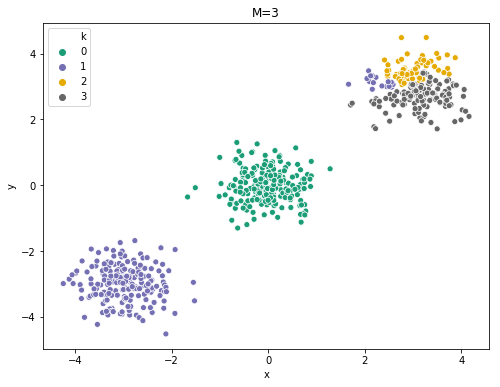

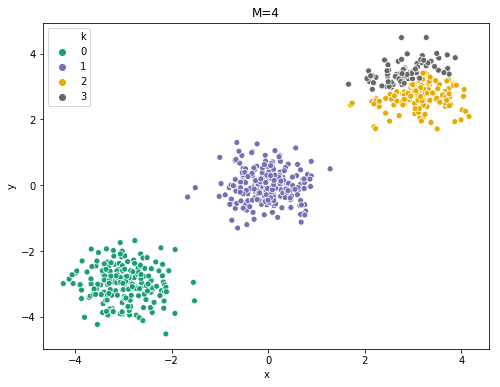

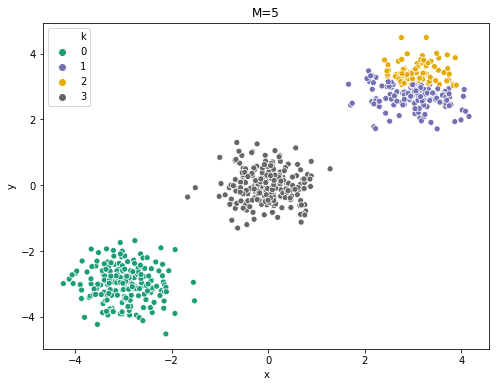

In [77]:
test(X, 4, 5)

## Test 2

W przypadku, kiedy skupiska punktów nie są od siebie tak wyraźnie oddzielone jak poprzednio też jest całkiem ok, jednak dopiero od M=8.

In [79]:
n = 200
X1 = np.c_[np.random.uniform(0,1,n), np.random.uniform(0,1,n)] 
X2 = np.c_[np.random.uniform(0,1,n), np.random.uniform(1,2,n)] 
X3 = np.c_[np.random.uniform(0,1,n), np.random.uniform(2,3,n)] 
X = np.r_[X1, X2, X3]

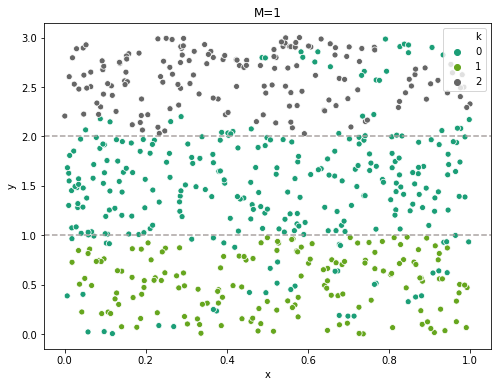

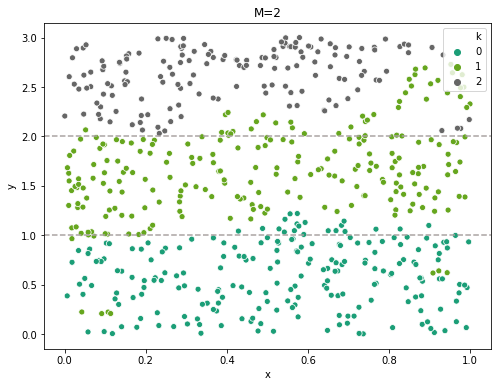

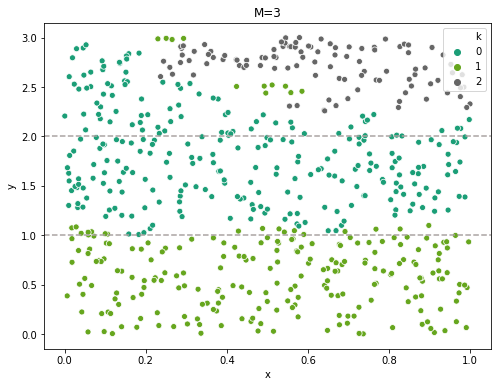

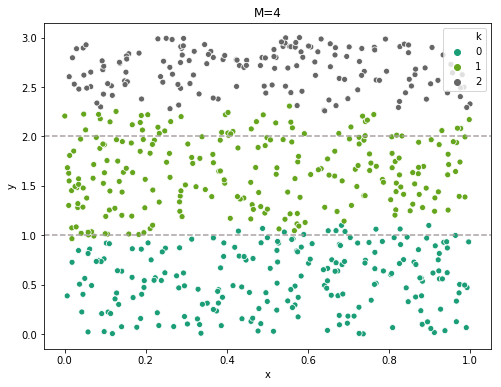

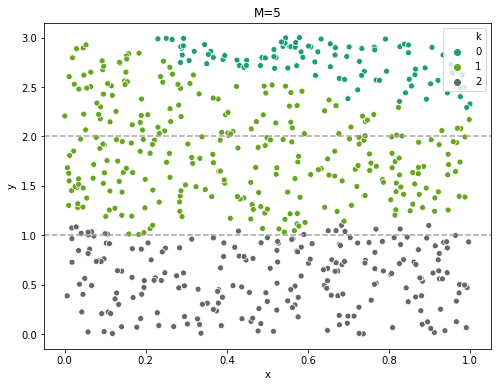

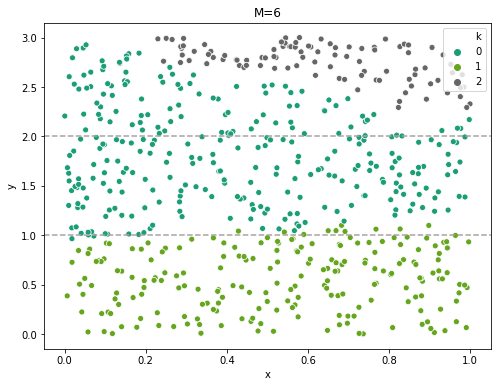

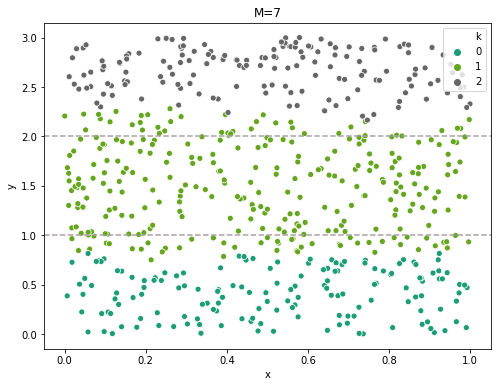

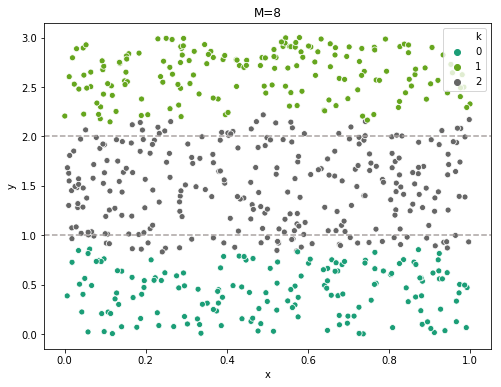

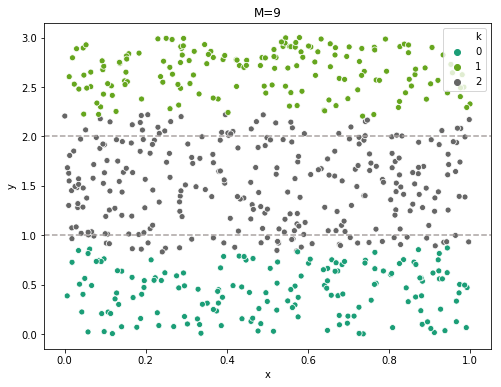

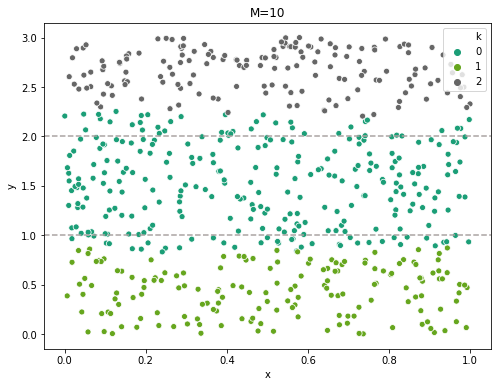

In [80]:
test2(X, 3, 10)

## Test 3

Ostatni test został przeprowadzony na zbiorze punktów bez żadnego założonego z góry podziału. Ponownie podział wyznaczany przez algorytm wygląda sensownie, zarówno dla małych jak i trochę większych k, jednak tylko dla większych M.  

In [89]:
n = 500
X = np.c_[np.random.uniform(0,1,n), np.random.uniform(0,1,n)] 

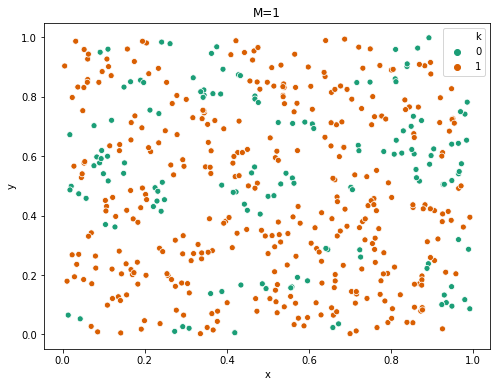

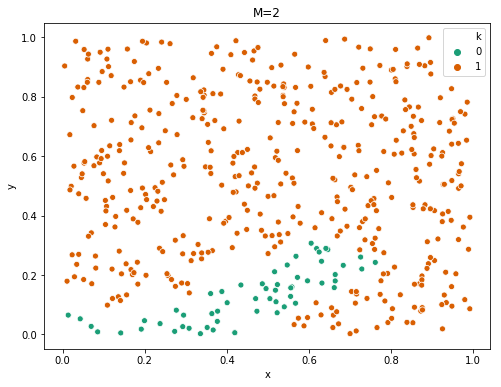

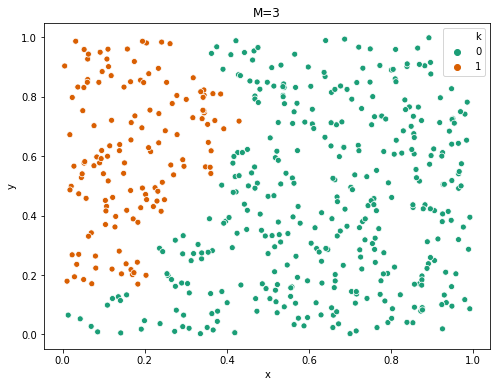

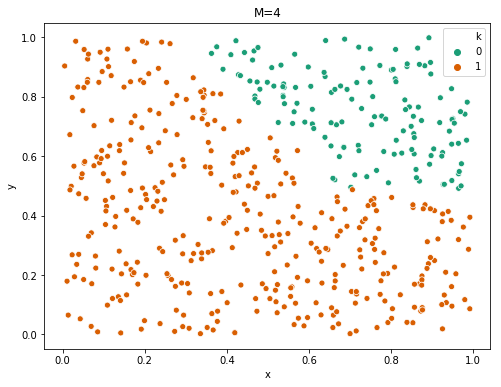

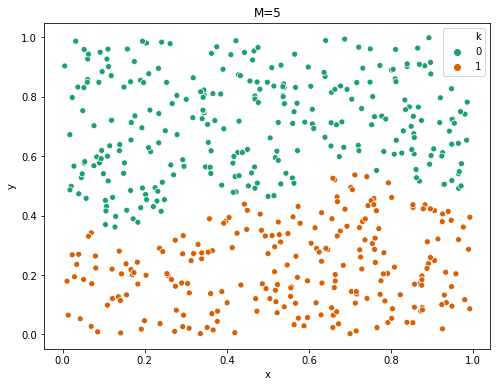

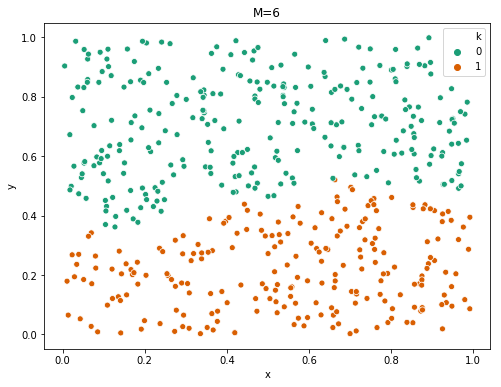

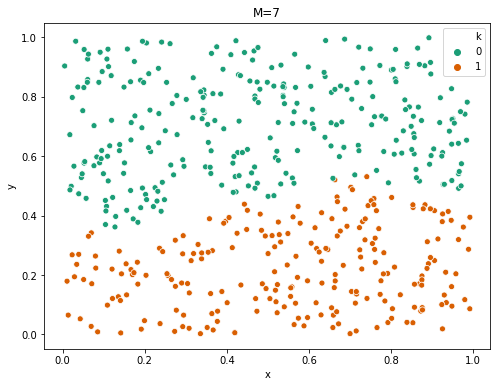

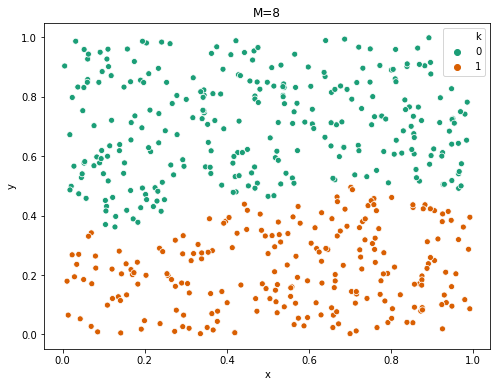

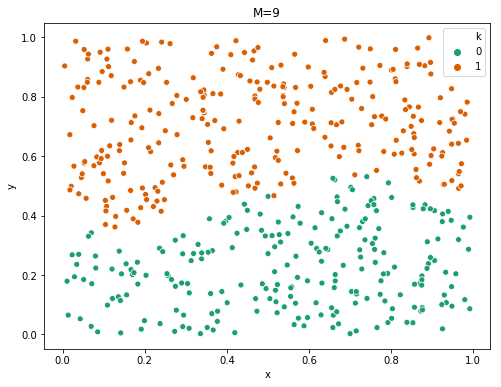

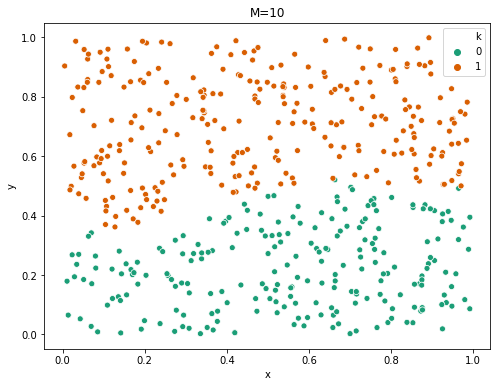

In [90]:
test(X, 2, 10)

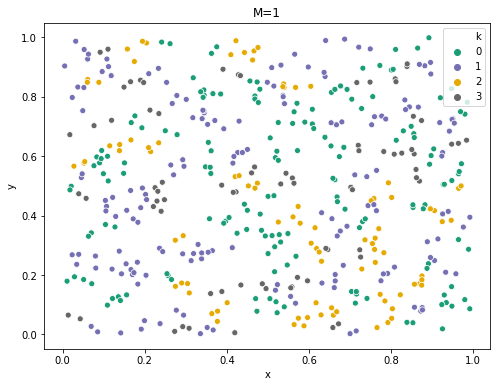

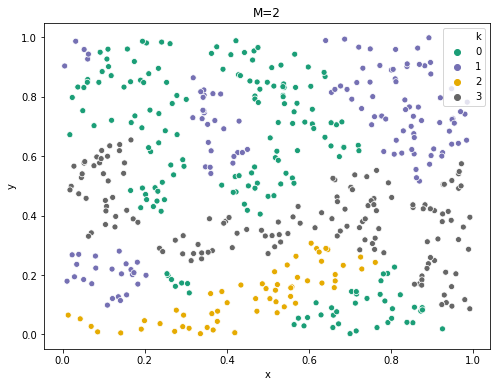

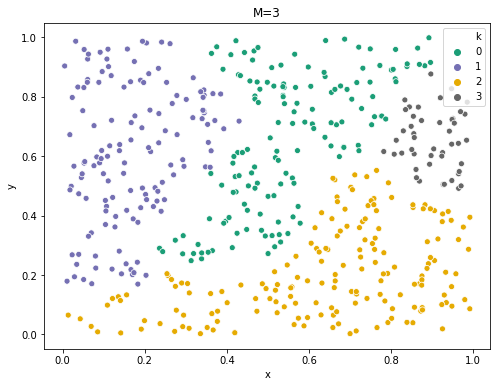

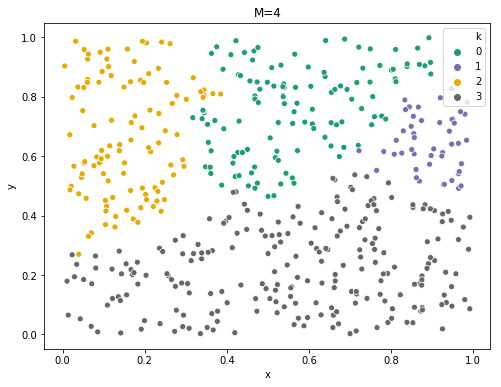

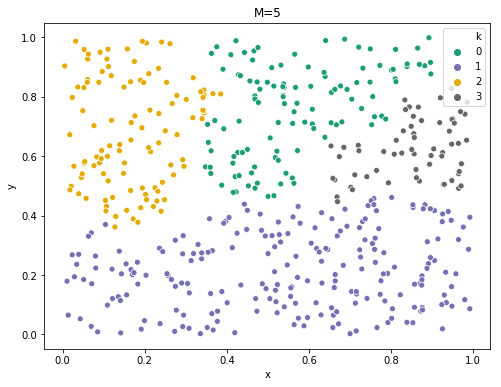

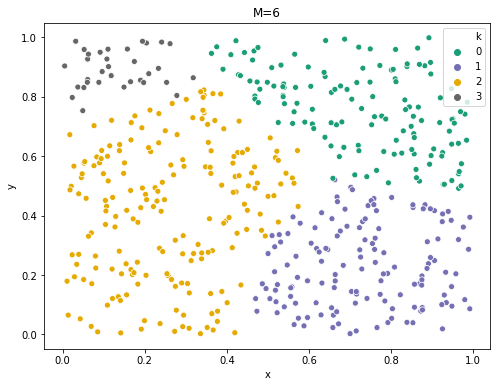

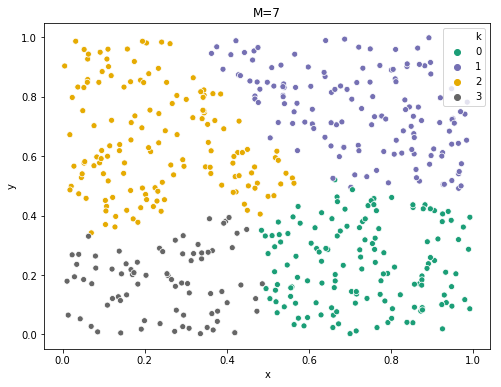

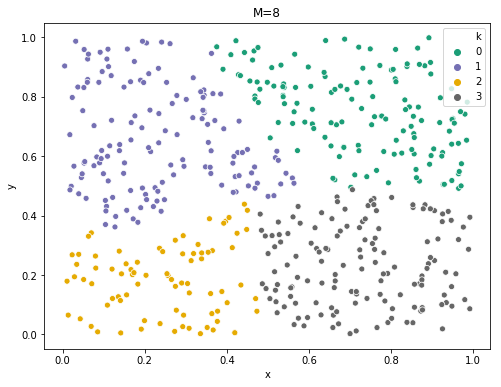

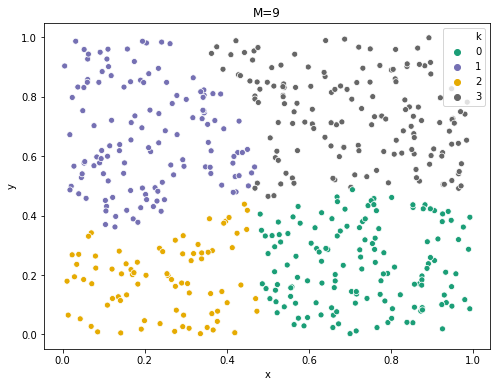

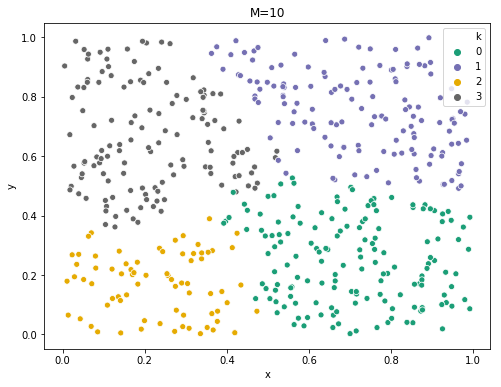

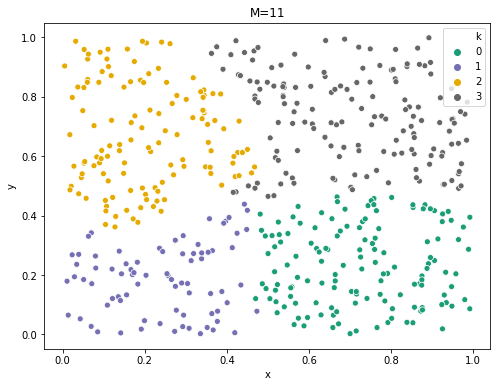

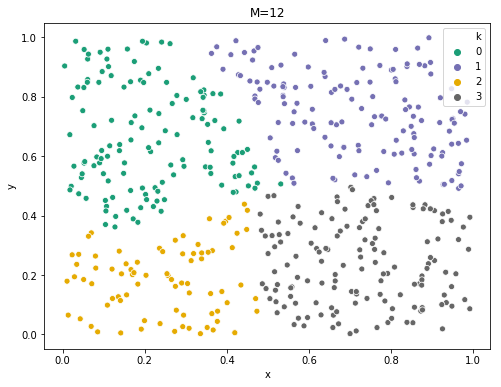

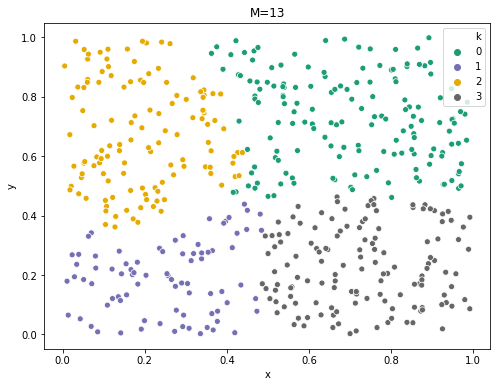

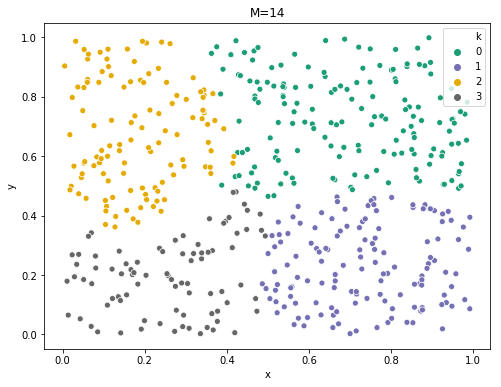

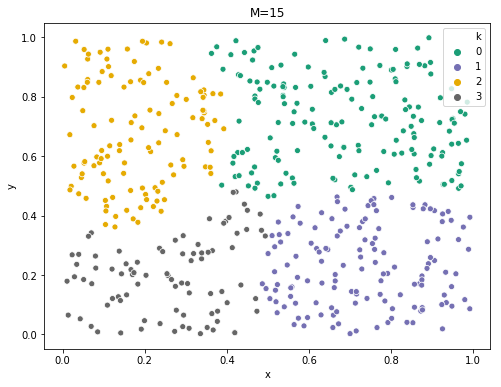

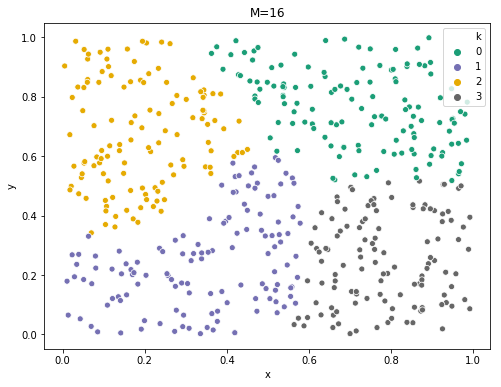

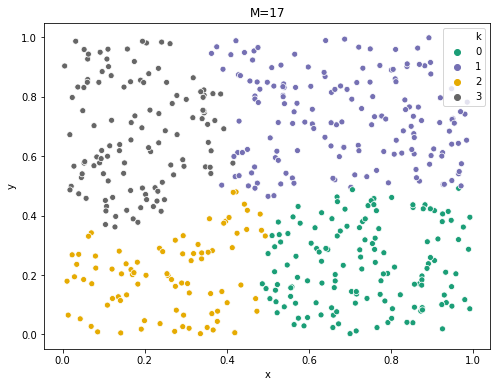

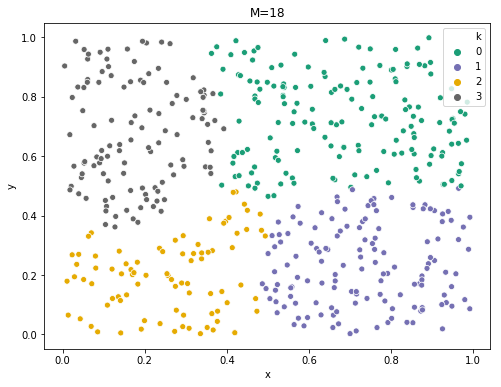

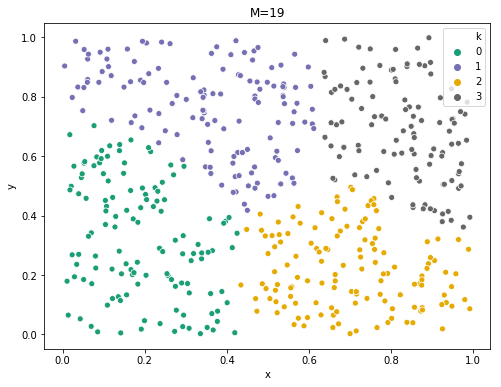

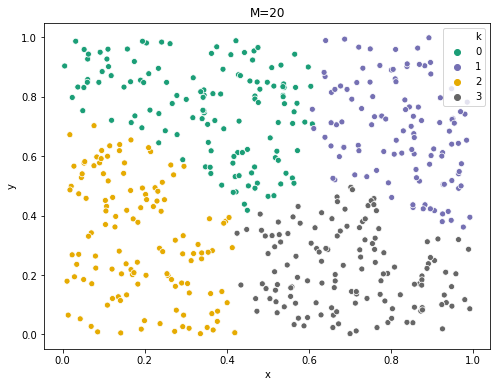

In [93]:
test(X, 4, 20)

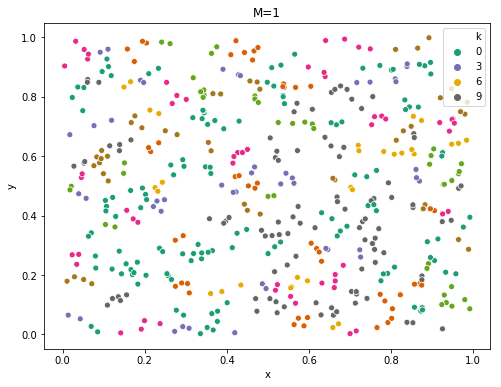

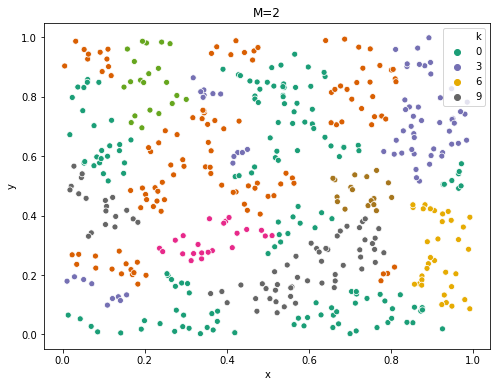

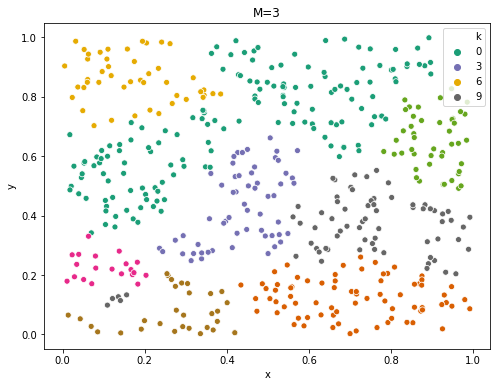

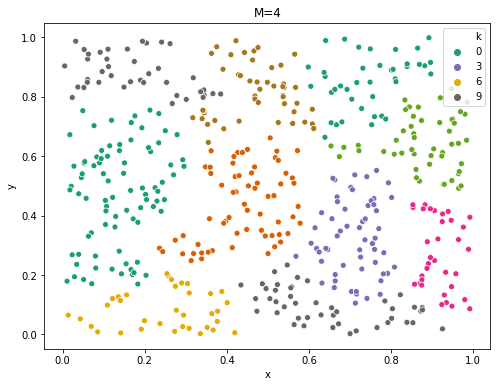

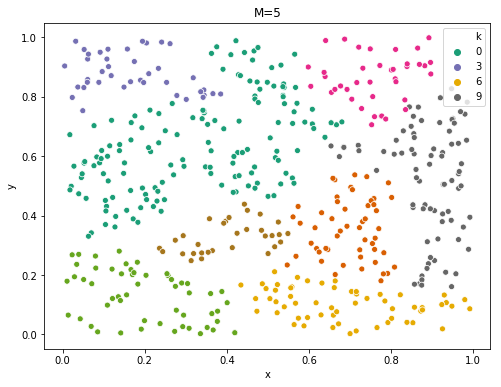

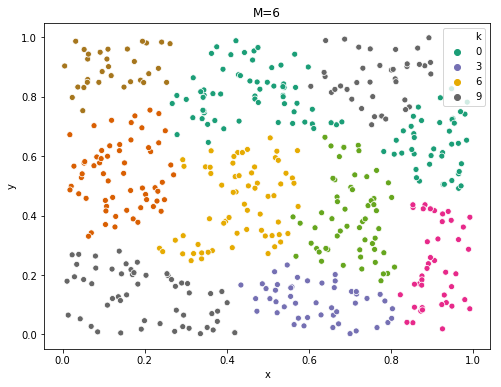

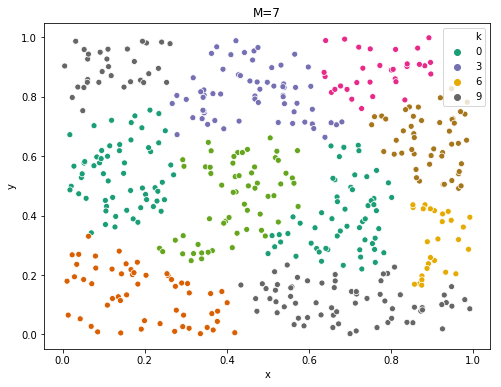

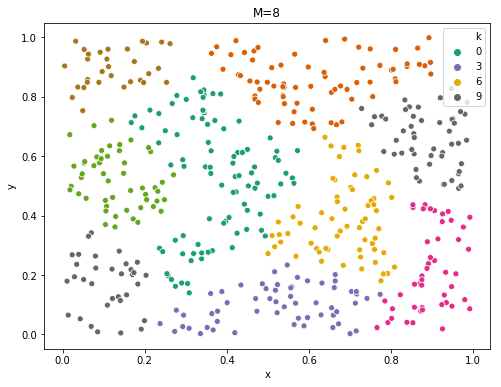

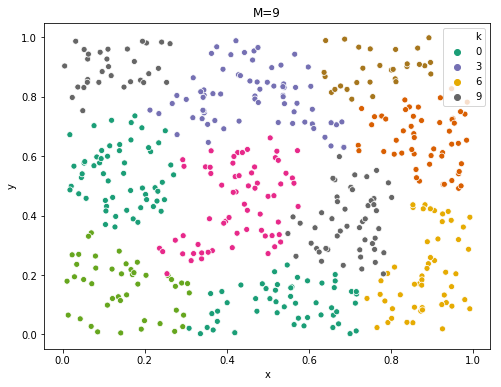

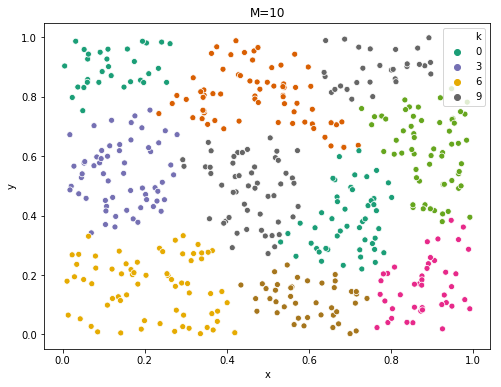

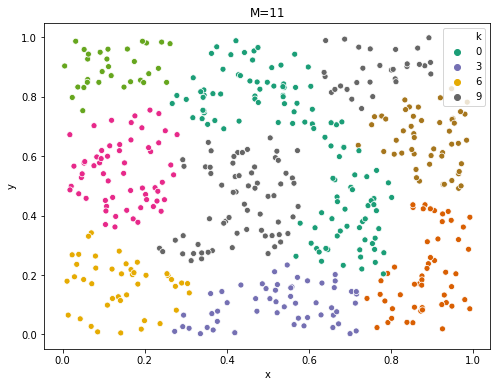

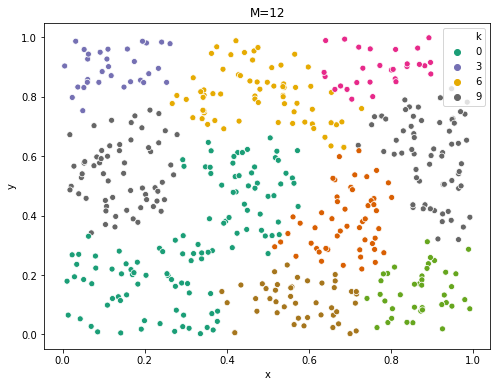

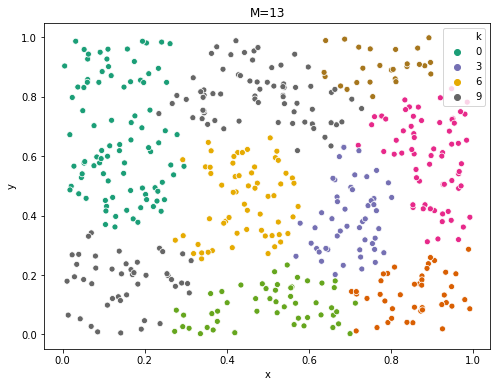

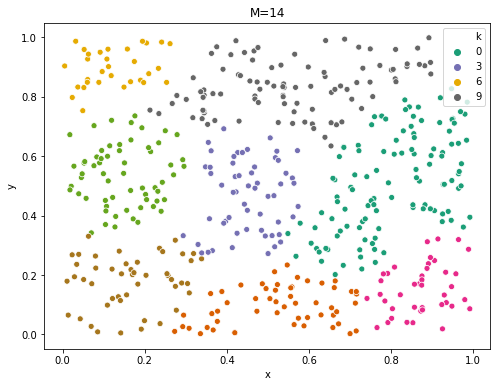

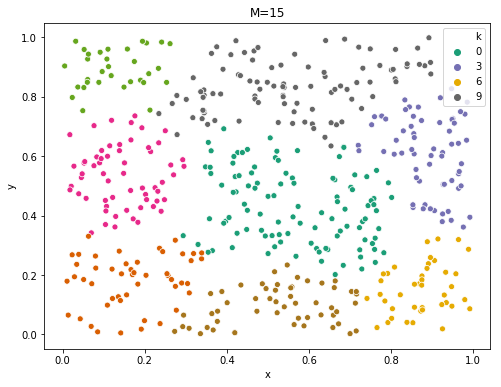

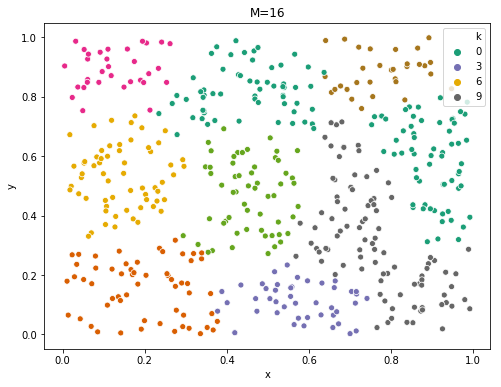

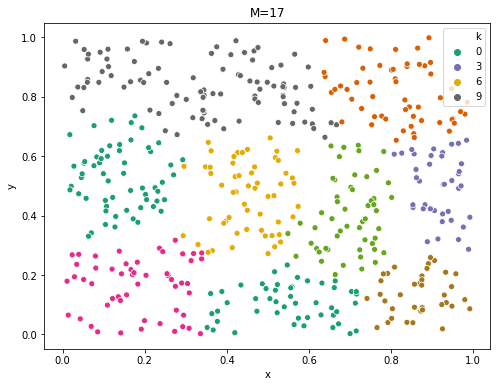

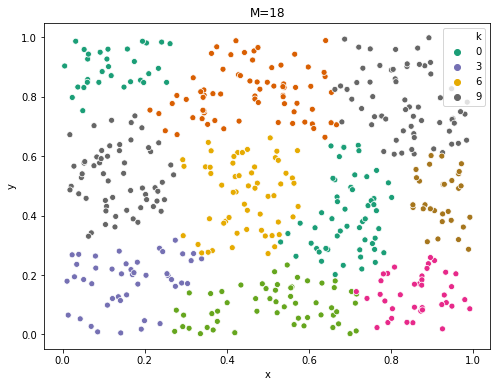

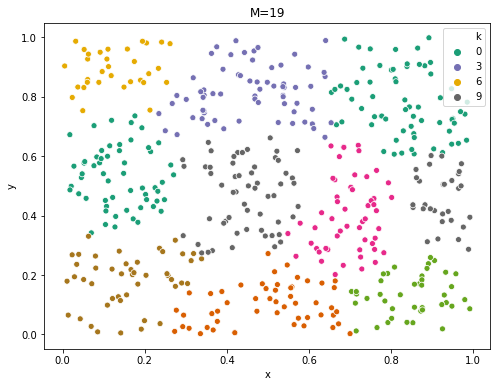

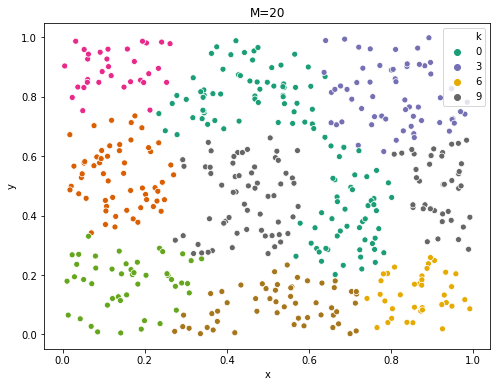

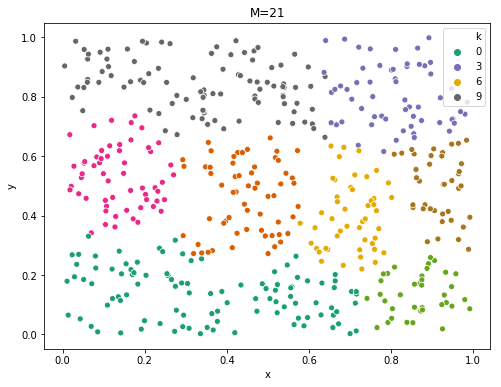

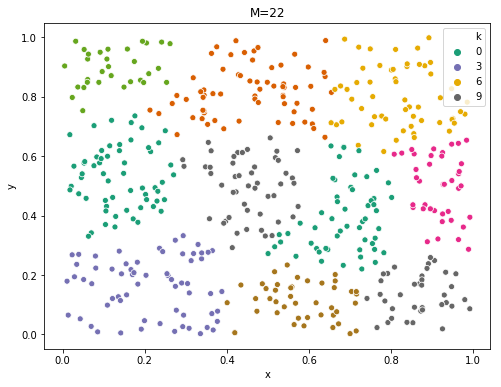

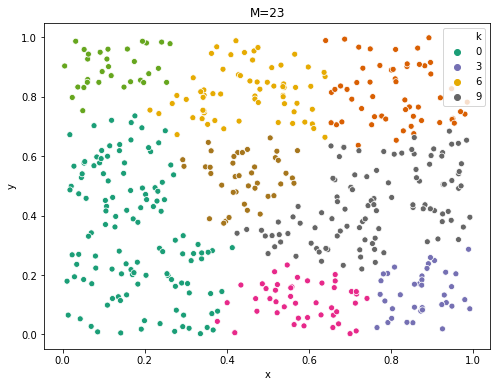

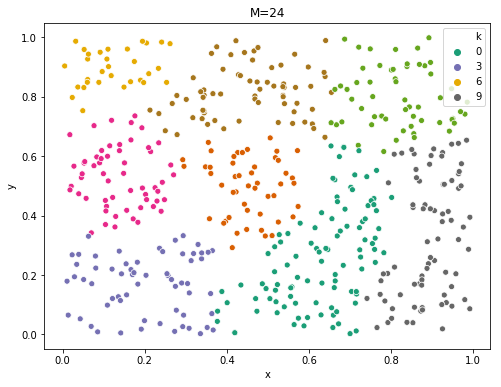

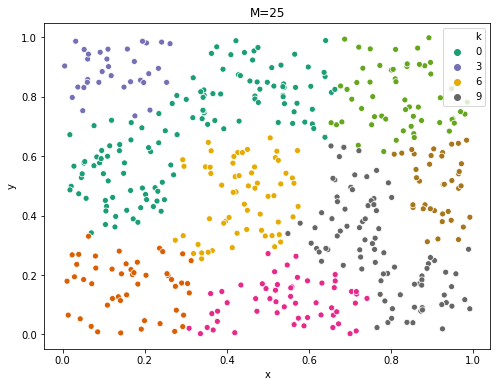

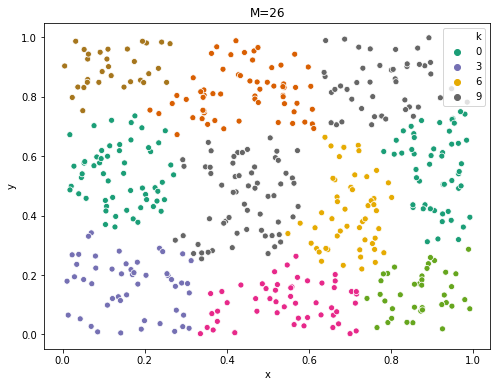

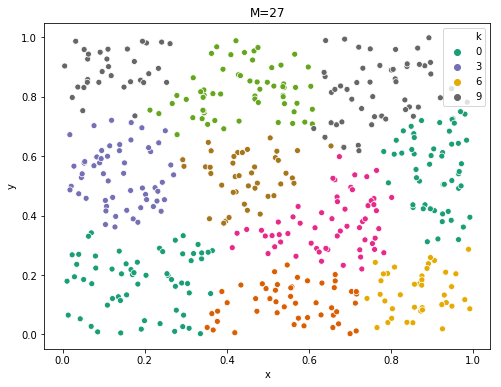

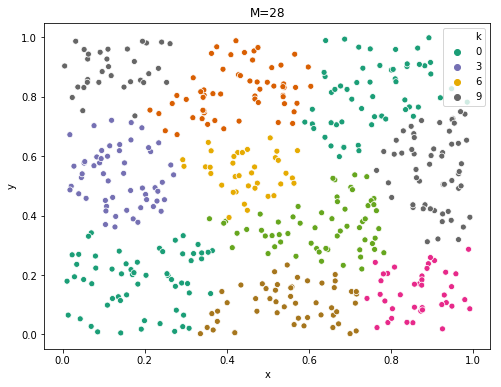

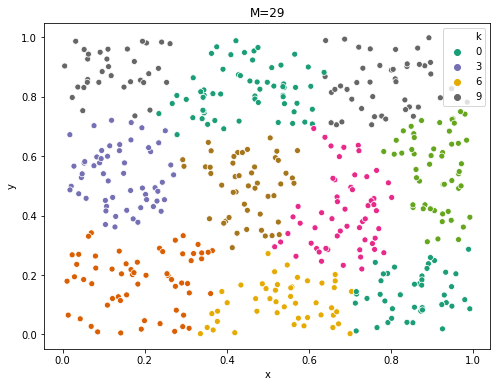

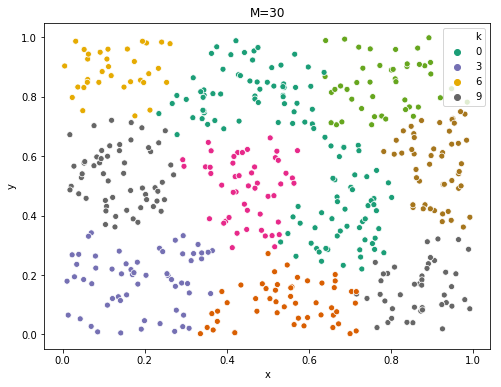

In [94]:
test(X, 10, 30)